In this notebook, we'll filter the samples of the SwissProt dataset to only include those that have annotations that were experimentally verified or inferred by a human curator. We'll also remove any duplicate GO terms that may be assigned to the same sample.

/home/andrew/Workspace/AmiGO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


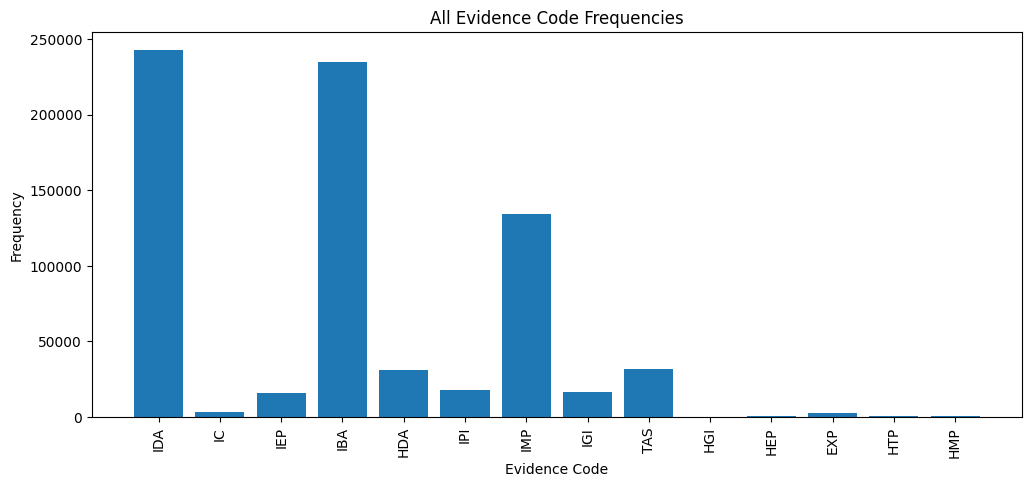

Dataset saved to ./dataset/all-filtered.jsonl
Filtered proportion: 89.31%


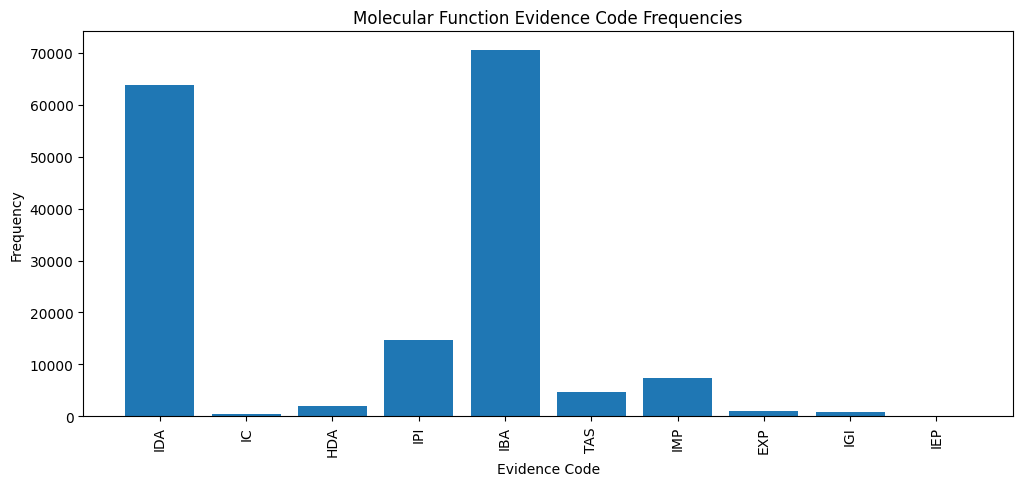

Dataset saved to ./dataset/mf-filtered.jsonl
Filtered proportion: 83.81%


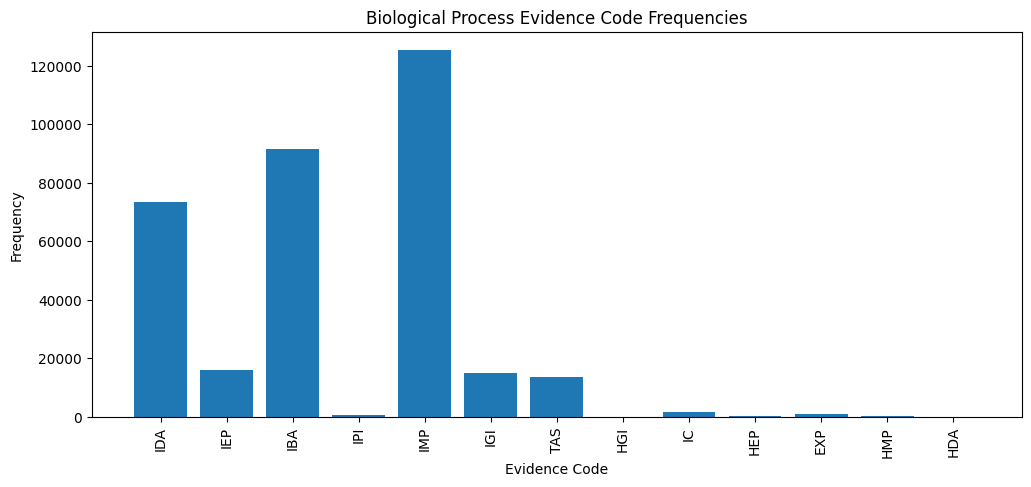

Dataset saved to ./dataset/bp-filtered.jsonl
Filtered proportion: 81.29%


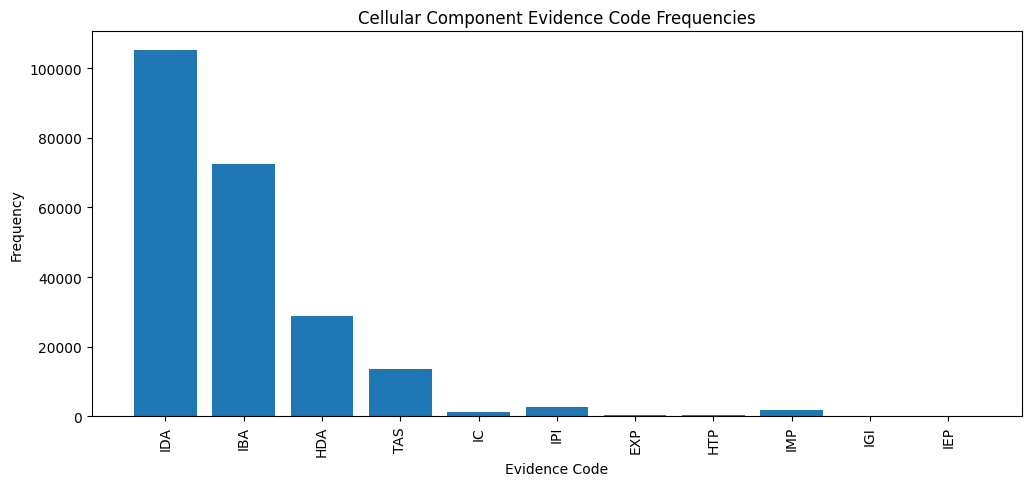

Dataset saved to ./dataset/cc-filtered.jsonl
Filtered proportion: 81.92%


In [1]:
from datasets import load_dataset

from collections import Counter

import obonet

import matplotlib.pyplot as plt

import json

hf_dataset_name = "andrewdalpino/SwissProt-Gene-Ontology"

all_filtered_path = "./dataset/all-filtered.jsonl"
mf_filtered_path = "./dataset/mf-filtered.jsonl"
bp_filtered_path = "./dataset/bp-filtered.jsonl"
cc_filtered_path = "./dataset/cc-filtered.jsonl"

# Download the OBO file from https://geneontology.org/docs/download-ontology.
go_obo_path = "./dataset/go-basic.obo"

graph = obonet.read_obo(go_obo_path)

# Refer to https://geneontology.org/docs/guide-go-evidence-codes/.
EXPERIMENTAL_CODES = {"EXP", "IDA", "IPI", "IMP", "IGI", "IEP"}

HIGH_THROUGHPUT_CODES = {"HTP", "HDA", "HMP", "HGI", "HEP"}

PHYLOGENETICALLY_INFERRED_CODES = {"IBA", "IBD", "IKR", "IRD"}

COMPUTATIONAL_ANALYSIS_CODES = {"ISS", "ISO", "ISA", "ISM", "IGC", "RCA"}

TRUSTED_SOURCE_CODES = {"TAS", "IC"}

UNTRUSTED_CODES = {"NAS", "ND"}

admissible_evidence_codes = frozenset(
    EXPERIMENTAL_CODES
    | HIGH_THROUGHPUT_CODES
    | TRUSTED_SOURCE_CODES
    | PHYLOGENETICALLY_INFERRED_CODES
)

dataset = load_dataset(hf_dataset_name, split="train")

for name, subset, filtered_path in [
    ("All", "all", all_filtered_path),
    ("Molecular Function", "mf", mf_filtered_path),
    ("Biological Process", "bp", bp_filtered_path),
    ("Cellular Component", "cc", cc_filtered_path),
]:
    counter = Counter()

    total_samples, num_filtered = 0, 0

    with open(filtered_path, "w") as file:
        for record in dataset:
            filtered_terms = set()
            unique_aspects = set()

            for go_term in record["go_terms"]:
                aspect = go_term["aspect"]

                if subset != "all" and aspect != subset:
                    continue

                go_id = go_term["id"]

                if go_id not in graph:
                    continue

                evidence_code = go_term["evidence_code"]

                if evidence_code not in admissible_evidence_codes:
                    continue

                filtered_terms.add(go_id)
                unique_aspects.add(aspect)
                counter[evidence_code] += 1

            total_samples += 1

            if len(filtered_terms) == 0:
                num_filtered += 1

                continue

            if subset == "all" and len(unique_aspects) != 3:
                num_filtered += 1

                continue

            record["go_terms"] = list(filtered_terms)

            file.write(json.dumps(record) + "\n")

    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Evidence Code Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Evidence Code")
    plt.ylabel("Frequency")

    plt.show()

    print(f"Dataset saved to {filtered_path}")

    print(f"Filtered proportion: {num_filtered / total_samples:.2%}")
